In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading csv file to check data
df=pd.read_csv('flower/flower_label.csv')
df.head(8)

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0
5,0006.png,1
6,0007.png,6
7,0008.png,0


In [3]:
#N_CLASSES = df['label'].nunique()
N_CLASSES = df.label.nunique()

N_CLASSES

10

C:\Users\Nvidia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


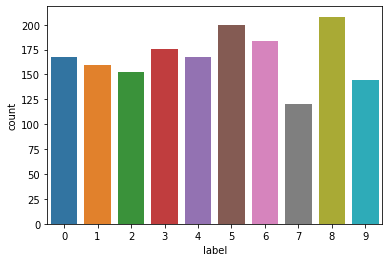

In [4]:
sns.countplot(df['label'])

In [5]:
# Preprocecss data if it has no image extension
#df["file_png"] = df["file"].apply(lambda x: x + ".png")
#df.head()

In [6]:
#delecting label == 1
#choosing data exept one label
#df2=df[df.label != 1]
#df2.head(8)

In [7]:
df['label'] = df['label'].astype('str')

In [8]:
df.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [9]:
BATCH_SIZE=32
HEIGHT, WIDTH = 224,224

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=30,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                validation_split = 0.1)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split = 0.1)

In [11]:
train_dir='flower/flower_imgs/'
train_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    directory= train_dir,
    x_col="file",
    y_col="label",
    class_mode="categorical", #categorical , binary , row
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode='rgb', #"rgb", "rgba", or "grayscale"
    target_size=(HEIGHT, WIDTH),
    subset='training',
    seed=0,)

Found 756 validated image filenames belonging to 10 classes.


C:\Users\Nvidia\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 840 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


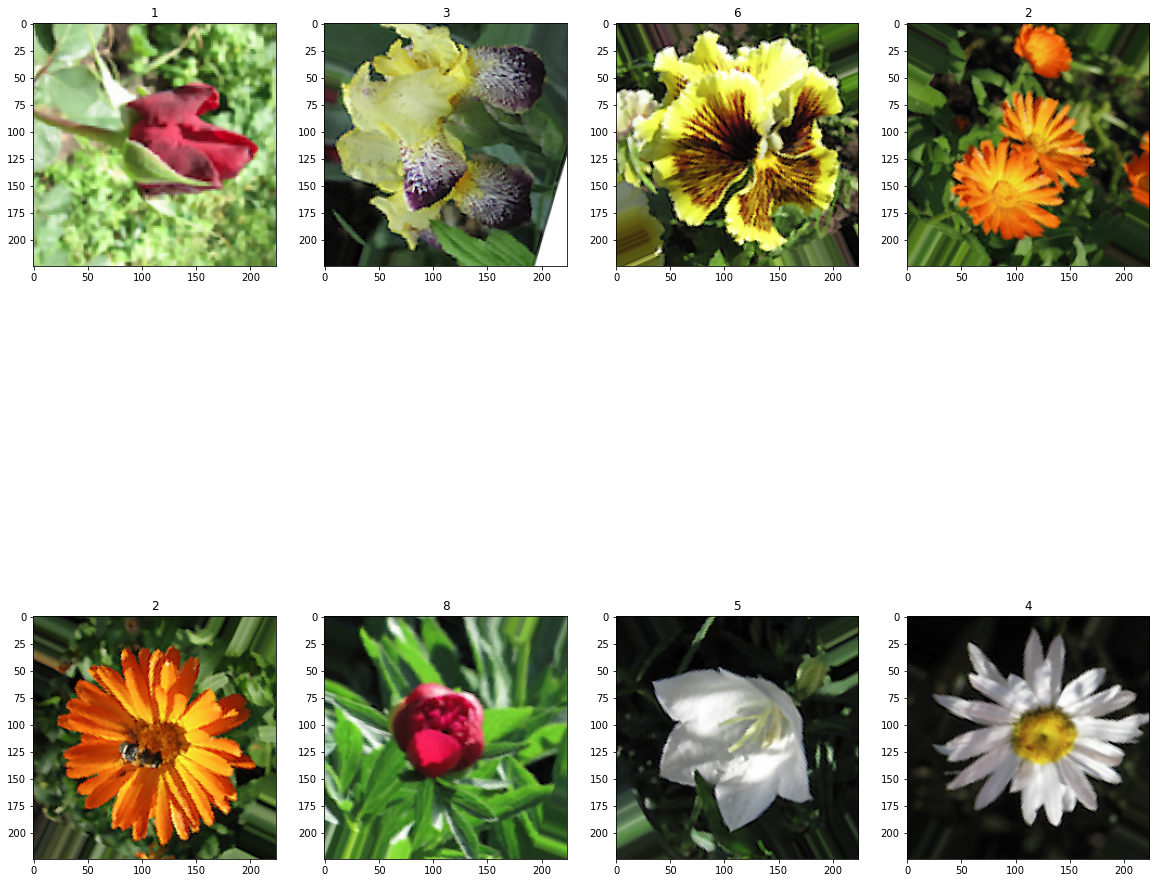

In [12]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [13]:
valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col="file",
    y_col="label",
    class_mode="categorical", 
    shuffle=False,
    batch_size=BATCH_SIZE, 
    color_mode='rgb', #grayscale
    target_size=(HEIGHT, WIDTH),
    validate_filenames=0.1,
    subset='validation',
    seed=0)


Found 84 validated image filenames belonging to 10 classes.


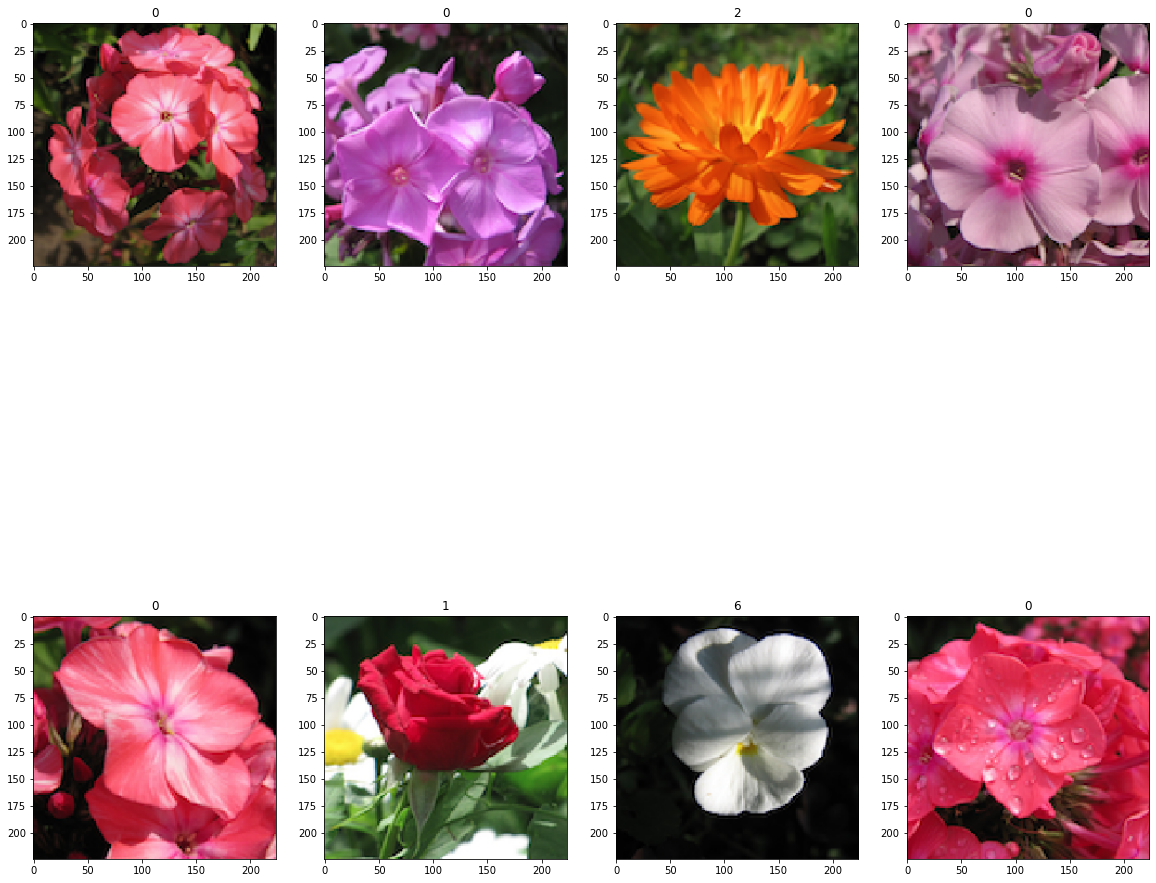

In [14]:
classes=list(valid_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [18]:
from tensorflow import keras
# Creating the model using the Sequential API
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, 
                padding="same", activation=keras.layers.LeakyReLU(alpha=0.02), name="Conv1", input_shape= (224,224,3)))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool1"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, 
                padding="same", activation=keras.layers.LeakyReLU(alpha=0.02), name="Conv2"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool2"))
model.add(keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, 
                padding="same", activation=keras.layers.LeakyReLU(alpha=0.02), name="Conv3"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool3"))

model.add(keras.layers.Flatten(name="Flatten1"))
model.add(keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.02), name="Dense1"))
model.add(keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.02), name="Dense2"))
model.add(keras.layers.Dense(10, activation="softmax", name="Output"))

# The model’s summary() method displays all the model’s layers
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 224, 224, 64)      9472      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 112, 112, 128)     204928    
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 56, 56, 256)       295168    
_________________________________________________________________
Pool3 (MaxPooling2D)         (None, 28, 28, 256)       0         
_________________________________________________________________
Flatten1 (Flatten)           (None, 200704)           

In [19]:
# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipvalue=1.0)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, clipvalue=1.0)

model.compile(loss="categorical_crossentropy", optimizer= optimizer, metrics=["accuracy"])

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.00001, patience=5,
                                      monitor="val_accuracy", min_lr=0.0000001)

# Interrupts training when it measures no progress on the validation set
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, monitor = "val_loss",
                                                  restore_best_weights=True)

In [20]:
# Training the model
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator) ,
                    epochs          = 10,  
                    validation_data = valid_generator, 
                    validation_steps=len(valid_generator),
                    callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/10
24/24 [==============================] - 14s 453ms/step - loss: 2.4010 - accuracy: 0.2222 - val_loss: 1.4532 - val_accuracy: 0.5000
Epoch 2/10
24/24 [==============================] - 8s 320ms/step - loss: 1.2700 - accuracy: 0.5714 - val_loss: 0.9666 - val_accuracy: 0.6786
Epoch 3/10
24/24 [==============================] - 8s 318ms/step - loss: 0.9611 - accuracy: 0.6534 - val_loss: 0.9066 - val_accuracy: 0.6905
Epoch 4/10
24/24 [==============================] - 8s 321ms/step - loss: 0.7827 - accuracy: 0.7368 - val_loss: 0.8711 - val_accuracy: 0.6429
Epoch 5/10
24/24 [==============================] - 8s 317ms/step - loss: 0.8085 - accuracy: 0.7275 - val_loss: 0.8901 - val_accuracy: 0.6548
Epoch 6/10
24/24 [==============================] - 8s 319ms/step - loss: 0.6992 - accuracy: 0.7460 - val_loss: 0.8132 - val_accuracy: 0.7024
Epoch 7/10
24/24 [==============================] - 8s 323ms/step - loss: 0.5889 - accuracy: 0.7923 - val_loss: 0.8187 - val_accuracy: 0.7500
Epoch

In [21]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

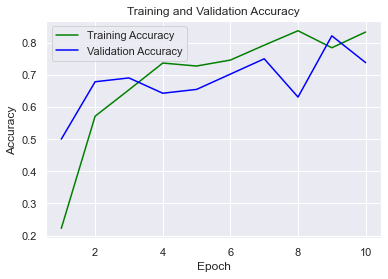

In [22]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

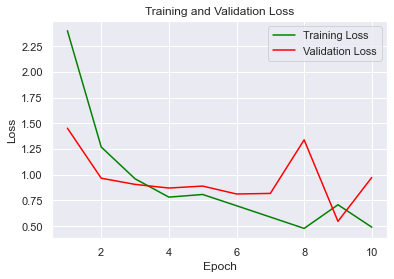

In [23]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

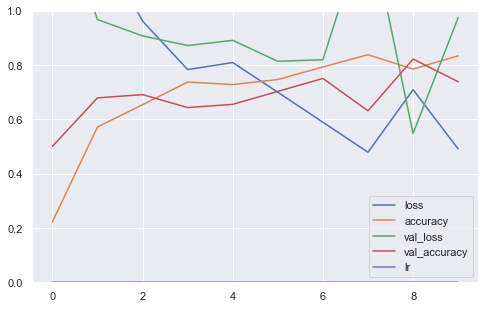

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
predictions = model.predict(valid_generator)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(valid_generator.classes, predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00        10
           4       0.86      1.00      0.92         6
           5       0.47      1.00      0.64         7
           6       1.00      0.42      0.59        12
           7       0.80      1.00      0.89         8
           8       1.00      0.86      0.92         7
           9       0.33      0.83      0.48         6

    accuracy                           0.74        84
   macro avg       0.74      0.79      0.73        84
weighted avg       0.75      0.74      0.71        84



C:\Users\Nvidia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nvidia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nvidia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


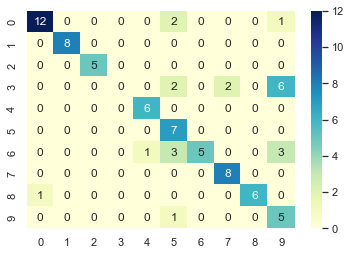

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_generator.classes, predictions.argmax(axis=-1))

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [ ]:
img = cv2.imread("Y2.jpg")
H,W,C = 224,224,3
img = cv2.resize(img, (H, W)) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = np.array(img)
img = img.astype("float32")  
img = img / 255.0

img = img.reshape(1,H,W,C)
print(img.shape)

prediction = np.argmax(model.predict(img),axis=-1)
print(prediction)


In [ ]:
# https://gradio.app/docs/

import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import requests
import cv2

def inference(img):
    labels =['benign', 'malignant']
    H,W,C = 224,224,3
    img = cv2.resize(img, (H, W)) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2BGR)
    img = np.array(img)
    img = img.astype("float32")/255.0
    img = img.reshape(1,H,W,C)
    pred = model.predict(img).flatten()
    prediction = [pred[0], pred[1], pred[2], pred[3], pred[4], pred[5], pred[6], pred[7], pred[8], pred[9]]
    dictionary = dict(zip(labels, map(float, prediction)))
    return dictionary

nbr_top_classes = 10
gr.Interface(fn=inference, 
             inputs=gr.inputs.Image(), 
             outputs=gr.outputs.Label(num_top_classes=nbr_top_classes),
             theme="dark"
             ).launch(share=True) #, debug=True Use in Colab
